In [1]:
import torch
import torch.nn as nn
# from generate_data import *
import matplotlib.pyplot as plt
import numpy as np
import math 
from load_matlab_timedata import get_data_from
import sklearn.preprocessing 
from tqdm import tqdm_notebook as tqdm
import random
import yaml
import h5py
from torch.utils.data import Dataset, DataLoader, SequentialSampler, BatchSampler

In [2]:
! ls DC_motor_simulation

dc_engine_random_sig_const_periods.slx		 diff_eq_system.slx
dc_engine_random_sig_random_period.slx		 diff_eq_system.slx.original
dc_engine_random_sig_random_period.slx.autosave  res.mat
dc_engine_random_sig_random_period.slxc		 resources
DC_motor_simulation.prj				 slprj


In [3]:
plt.rcParams['figure.figsize'] = 20, 7.

In [37]:
CONFIG_FILENAME = "model_params.yaml"

In [67]:
with open(CONFIG_FILENAME, 'r') as f:
        config = yaml.load(f, Loader=yaml.FullLoader)

In [68]:
config

{'data_params': {'need_normalize': True,
  'mat_file': 'DC_motor_simulation/res.mat',
  'leave_nth': 13,
  'test_size': 0.3},
 'network_params': {'input_size': 128,
  'per_element': True,
  'h1': 16,
  'output_dim': 1,
  'num_layers': 2,
  'dtype': 'torch.float'},
 'train_params': {'learning_rate': 0.001,
  'num_epochs': 15,
  'batch_size': 512,
  'loss_fn': 'mse',
  'reduction': 'mean',
  'optimizer': 'adam'}}

In [69]:
p_data = config['data_params']
p_data

{'need_normalize': True,
 'mat_file': 'DC_motor_simulation/res.mat',
 'leave_nth': 13,
 'test_size': 0.3}

In [70]:
p_net = config['network_params']
p_net

{'input_size': 128,
 'per_element': True,
 'h1': 16,
 'output_dim': 1,
 'num_layers': 2,
 'dtype': 'torch.float'}

In [71]:
p_train = config['train_params']
p_train

{'learning_rate': 0.001,
 'num_epochs': 15,
 'batch_size': 512,
 'loss_fn': 'mse',
 'reduction': 'mean',
 'optimizer': 'adam'}

In [72]:
def get_func_timeseries(func, diapasone = (0, math.pi * 10, math.pi / 100)):
    T = [ t for t in np.arange(diapasone[0], diapasone[1], diapasone[2])]
    T = T[:num_datapoints]
    func_t = [func(t) for t in T]
    plt.plot(func_t)
    x = np.array(T)
    y = np.array(func_t)
    return (x,y)

In [73]:
try_sin = False
if try_sin:
    x, y = get_func_timeseries(func = math.sin)

In [74]:
#####################
# Set parameters
#####################

# Data params
# leave_nth = d_par['leave_nth' #KD: choosing simple value to avoid systematic error
# test_size = 0.3
# batch_size = 512
# # Network params
# input_size = 128
# # If `per_element` is True, then LSTM reads in one timestep at a time.
# per_element = True
if  p_net['per_element']:
    lstm_input_size = 1
else:
    lstm_input_size = p_net['input_size']
# size of hidden layers
# h1 = 16
# output_dim = 1
# num_layers = 2
# learning_rate = 1e-3
# num_epochs = 15
# dtype = torch.float


In [75]:
from torch.utils.data import Dataset, DataLoader, SequentialSampler
import sklearn.preprocessing 
class TimeSeriesDataset(Dataset):
    """Loads dataset from matlab file and provides batching interface"""

    def __init__(self, mat_file, retrospective_steps, partition, need_normalize=True, leave_nth = 1, transform=None):
        """
        Args:
            mat_file (string): Path to the mat file with annotations.
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        outfile = h5py.File(mat_file, 'r')
        #print(outfile.keys())
        self.data  = outfile['ans']
        time, x, y = self.data[::leave_nth, 0], self.data[::leave_nth, 1], self.data[::leave_nth, 2]
        if need_normalize:
            x_normalized, self.x_norms = sklearn.preprocessing.normalize(x.reshape(-1,1),
                                                      axis = 0,
                                                      norm = 'max',
                                                      return_norm = True)
            y_normalized, self.y_norms = sklearn.preprocessing.normalize(y.reshape(-1,1),
                                                      axis = 0,
                                                      norm = 'max', 
                                                      return_norm = True)
            x = x_normalized
            y = y_normalized
            
        print(x.shape)
        x = x[ int(partition[0] * x.shape[0]) : int(partition[1] * x.shape[0])]
        print(x.shape)
        y = y[ int(partition[0] * y.shape[0]) : int(partition[1] * y.shape[0])]
        x_sliding = []  # determines number of steps for retrospective view
        for i in range(1,retrospective_steps+1):
            x_sliding.append(x[i:-(retrospective_steps+1-i)])
        y = y[retrospective_steps:]
        #print(y.shape)
        self.x = torch.from_numpy(np.array(x_sliding)).type(torch.Tensor)
        self.y = torch.from_numpy(y).type(torch.Tensor).view(-1)
        #print(self.y.shape)
        self.transform = transform

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, idx):
        return self.x[:, idx], self.y[idx], idx

In [77]:
train_ts_ds = TimeSeriesDataset(mat_file=p_data['mat_file'],
                                retrospective_steps=p_net['input_size'],
                                partition=(0, 1 - p_data['test_size']),
                                need_normalize=p_data['need_normalize'],
                                leave_nth=p_data['leave_nth'])
test_ts_ds = TimeSeriesDataset(mat_file=d_par['mat_file'],
                                retrospective_steps=p_net['input_size'],
                                partition=(1 - p_data['test_size'], 1),
                                need_normalize=p_data['need_normalize'],
                               leave_nth=p_data['leave_nth'])

(76924, 1)
(53846, 1)
(76924, 1)
(23078, 1)


In [78]:
train_dl = DataLoader(dataset = train_ts_ds,
                 batch_sampler = BatchSampler(sampler = SequentialSampler(train_ts_ds), 
                              batch_size = p_train['batch_size'], drop_last = True))
test_dl = DataLoader(dataset = test_ts_ds,
                 batch_sampler = BatchSampler(sampler = SequentialSampler(test_ts_ds), 
                              batch_size = p_train['batch_size'], drop_last = True))


torch.Size([512, 128, 1])
128
torch.Size([512])


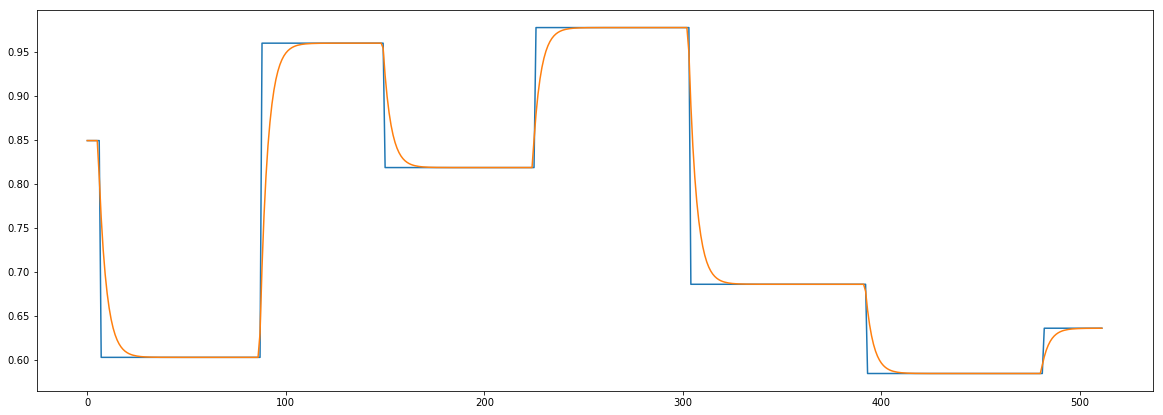

In [79]:
for i in test_dl:
    x, y, ind = i
    print(x.shape)
    x = x.transpose(0,1)
    plt.plot(x.detach().numpy()[-2])
    plt.plot(y.detach().numpy())
    print(len(x))
    print(y.shape)
    break

In [80]:

#####################
# Build model
#####################

# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        # Only take the output from the final timestep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        
        y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
        return y_pred.view(-1)
    
    def get_num_params(self):
        model_parameters = filter(lambda p: p.requires_grad, self.parameters())
        return sum([torch.prod(torch.Tensor(list(p.size()))) for p in model_parameters]).item()


In [82]:
model = LSTM(lstm_input_size,
             p_net['h1'],
             batch_size=p_train['batch_size'],
             output_dim=p_net['output_dim'],
             num_layers=p_net['num_layers'])

if p_train['loss_fn'] == 'mse':  
    loss_fn = torch.nn.MSELoss(reduction=p_train['reduction'])
elif p_train['loss_fn'] == 'l1':  
    loss_fn = torch.nn.L1Loss(reduction=p_train['reduction'])

if p_train['optimizer'] == "adam":
    optimiser = torch.optim.Adam(model.parameters(), lr=p_train['learning_rate'])

In [84]:
model.get_num_params()

3409.0

In [85]:
def plot_multiscale(plot_requests):
        fig, ax = plt.subplots()
        # Twin the x-axis twice to make independent y-axes.
        for i, req in enumerate(plot_requests):
            d, c = req
            ax.twinx().plot(d, color = c)
        plt.show()

In [86]:
def plot_shared_scale(plot_requests):
    for d, l in plot_requests:
        plt.plot(d, label = l)
    plt.legend()
    plt.show()

In [87]:
len(train_dl)

104

In [ ]:
num_epochs = p_train['num_epochs']

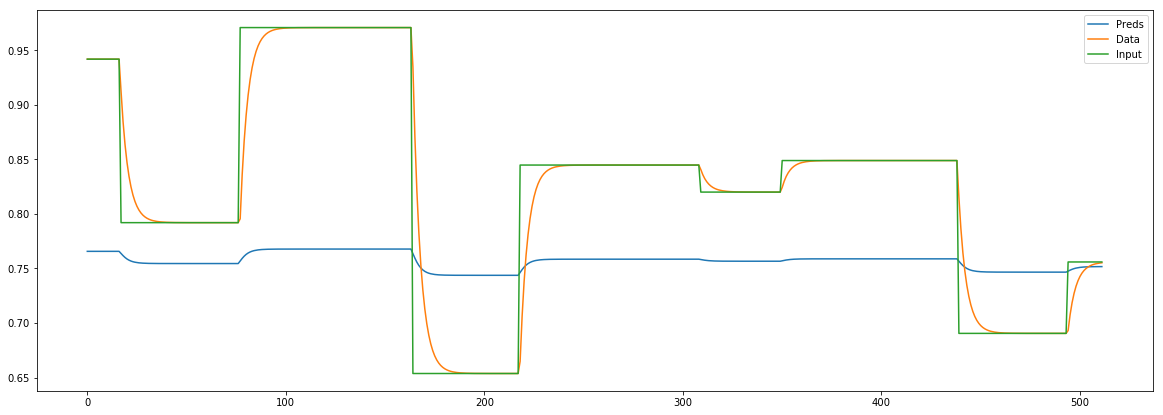

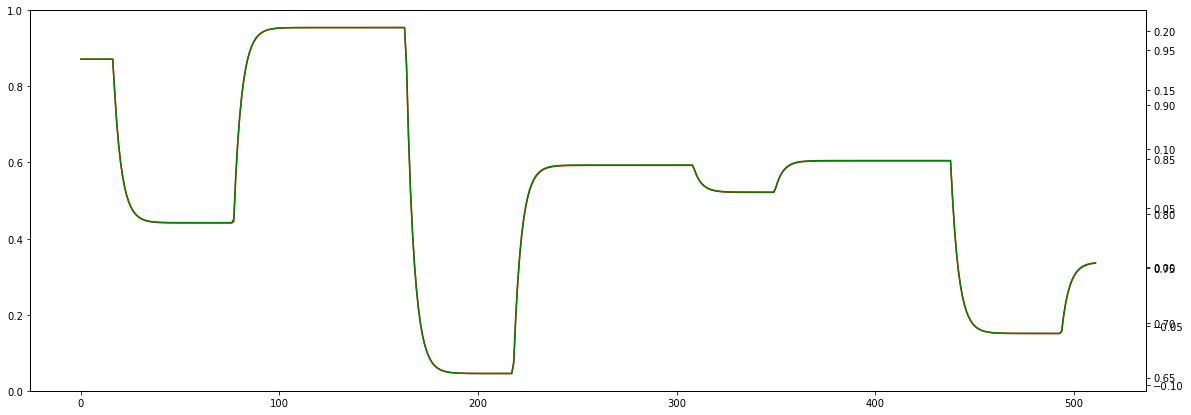

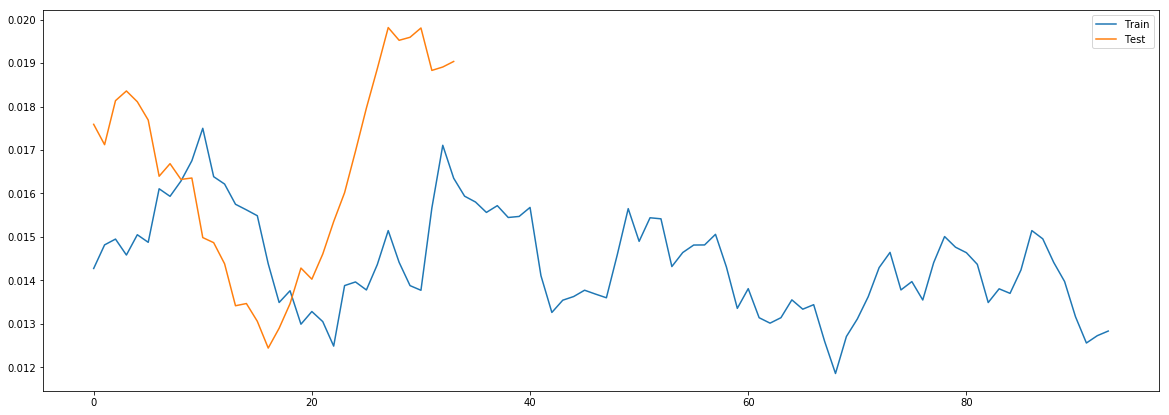

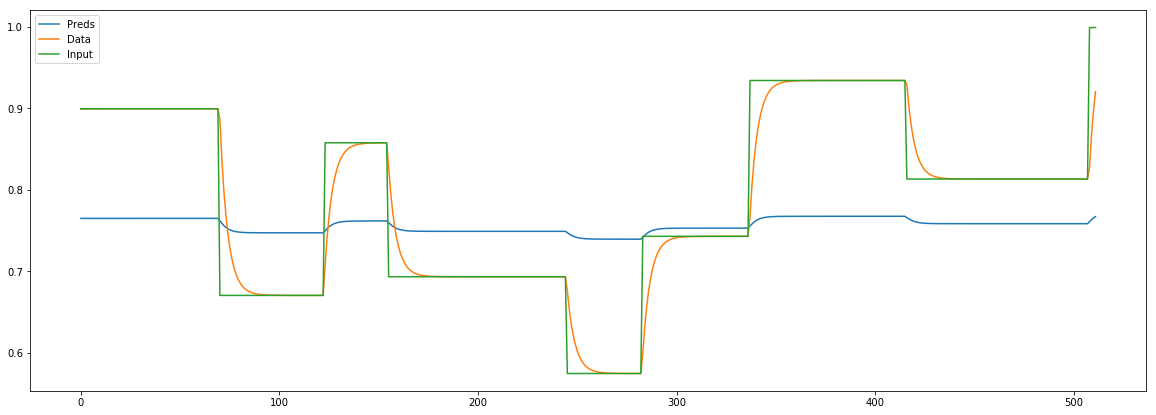

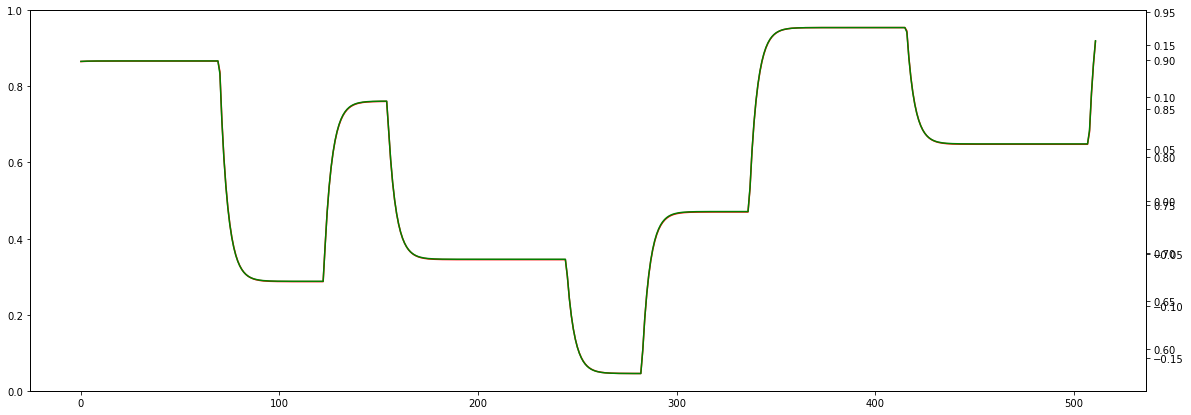

Epoch [0]     
 train_loss[0.028214195416344758]     
 eval_train[0.014292397039333502]     
 eval_test[0.016409581918692726] 


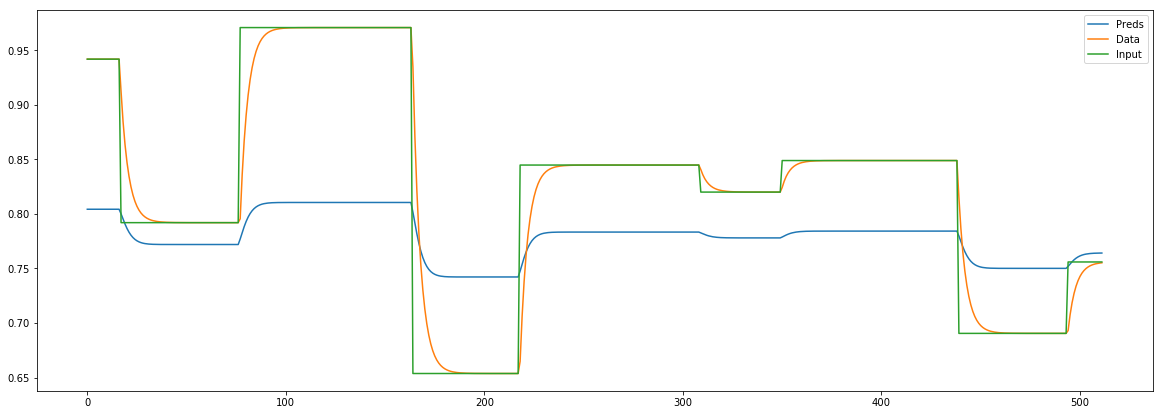

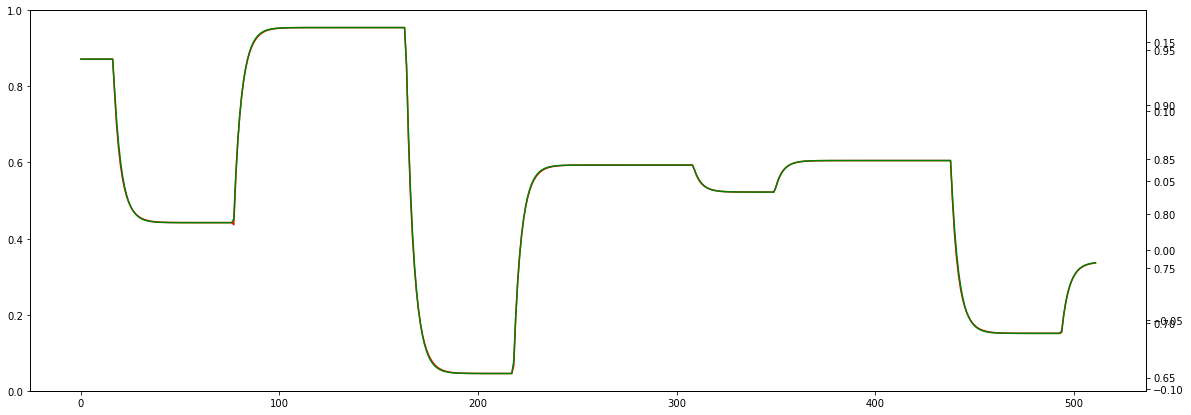

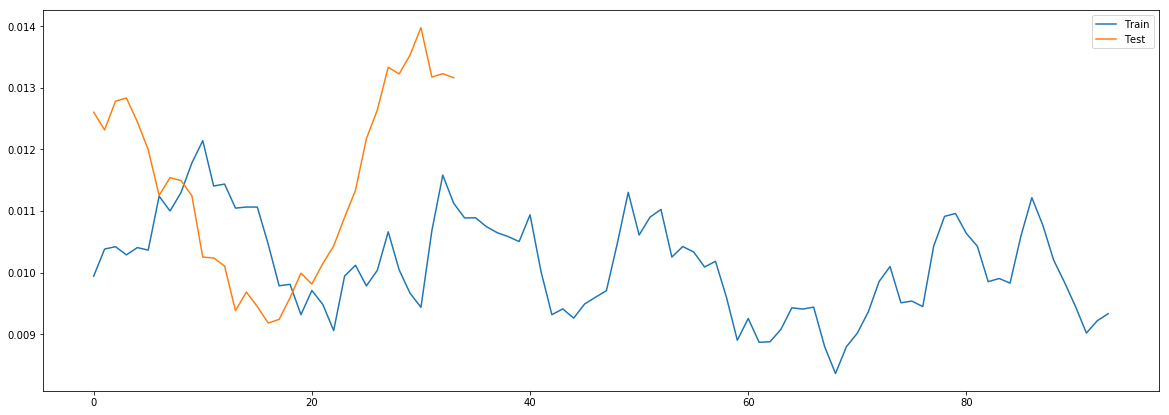

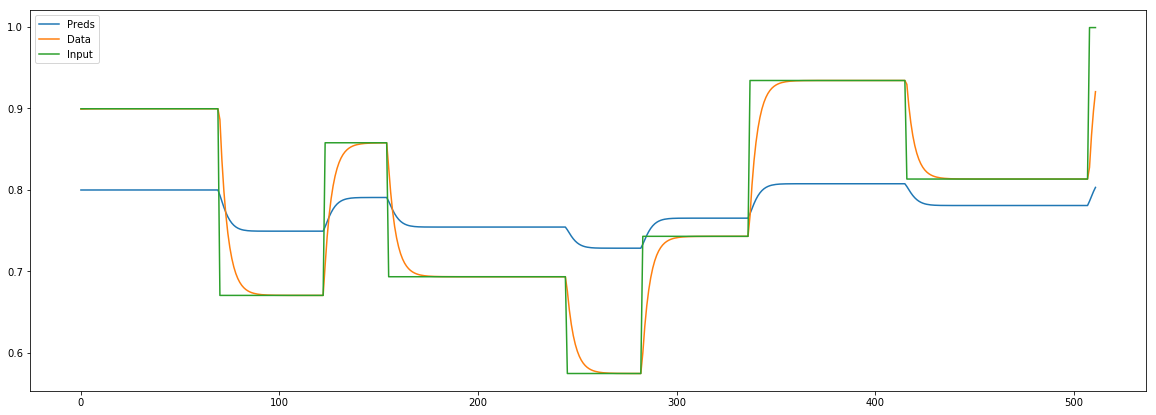

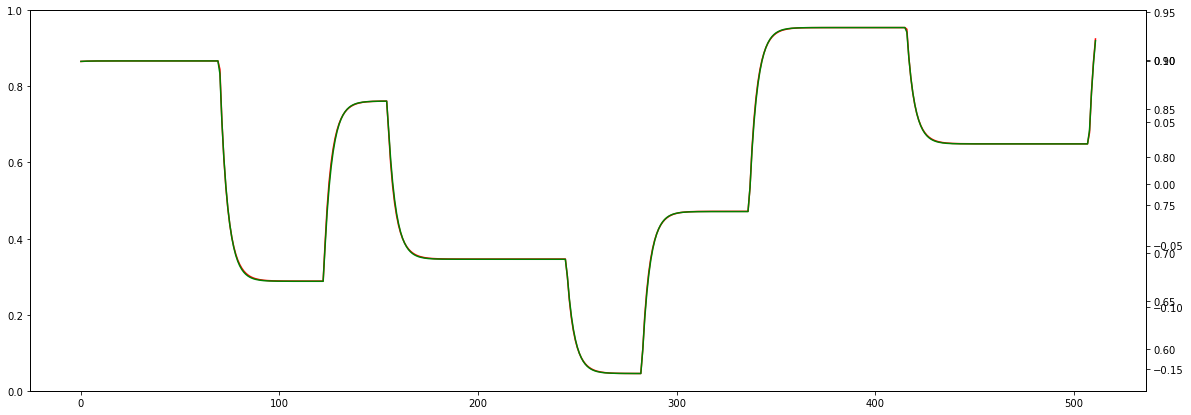

Epoch [1]     
 train_loss[0.01287470868555829]     
 eval_train[0.010031934760403462]     
 eval_test[0.011445543548854237] 


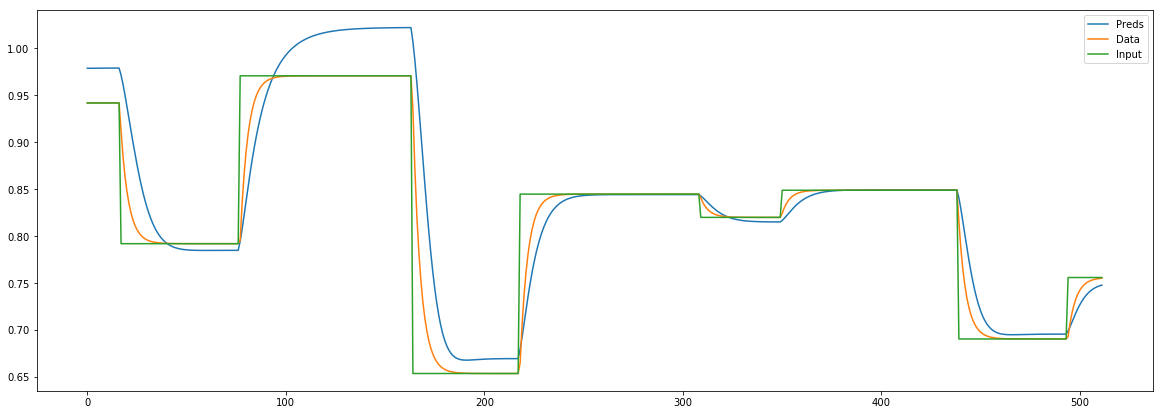

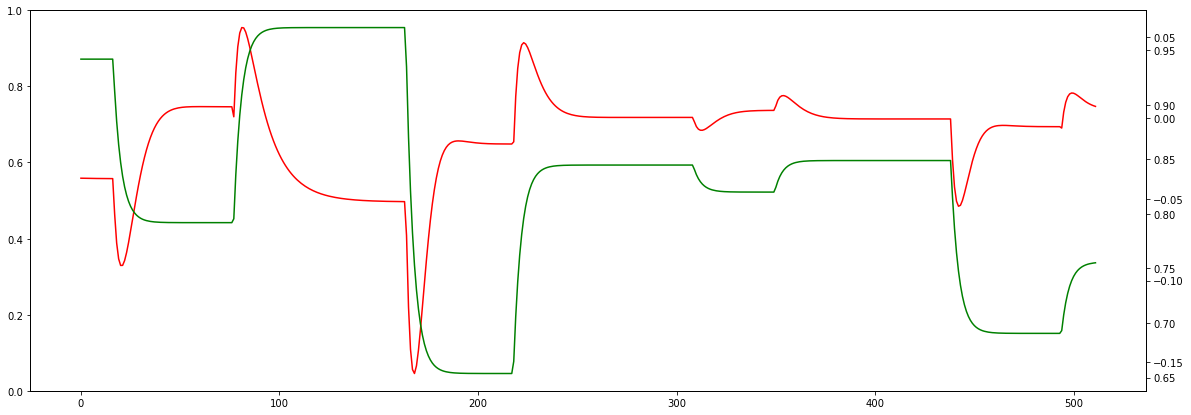

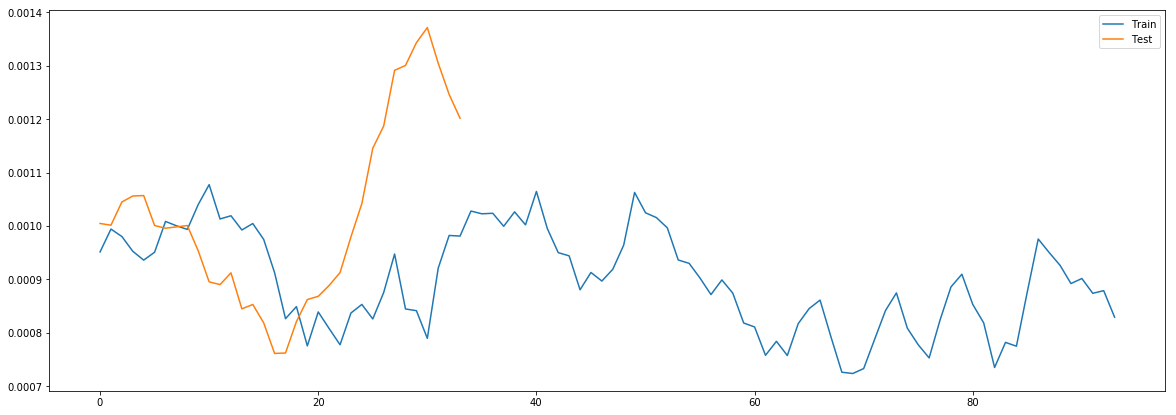

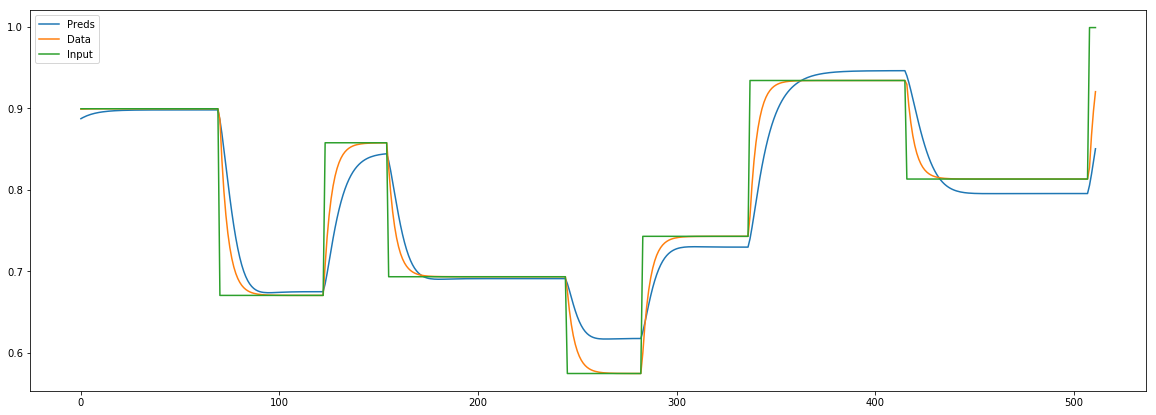

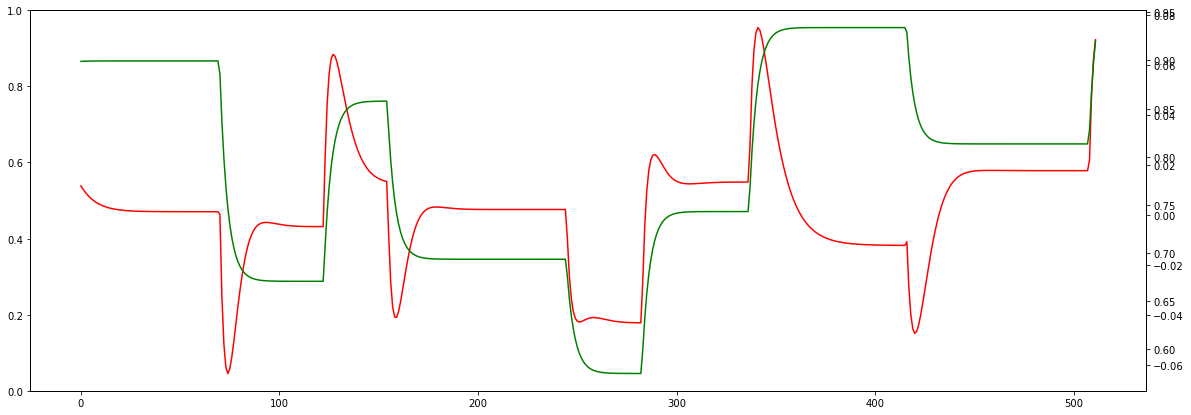

Epoch [2]     
 train_loss[0.003780807770314053]     
 eval_train[0.0008915942461708954]     
 eval_test[0.001001651294328357] 


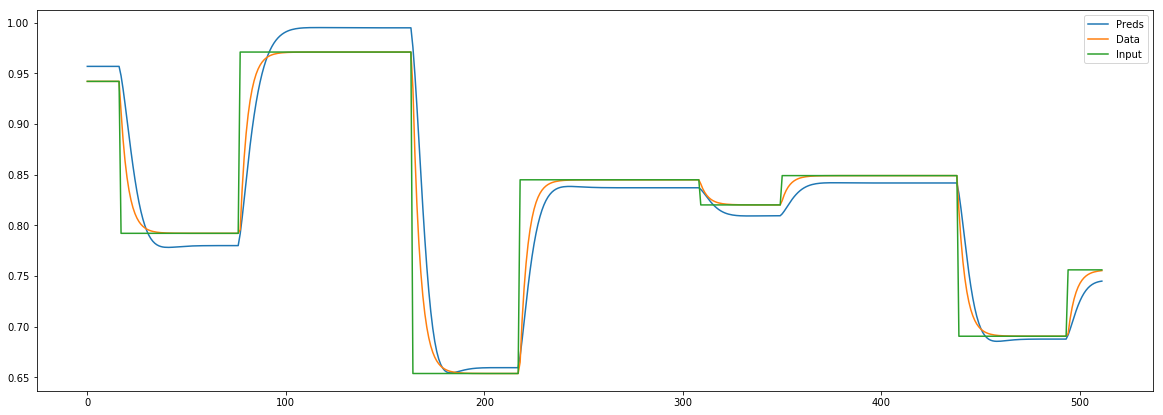

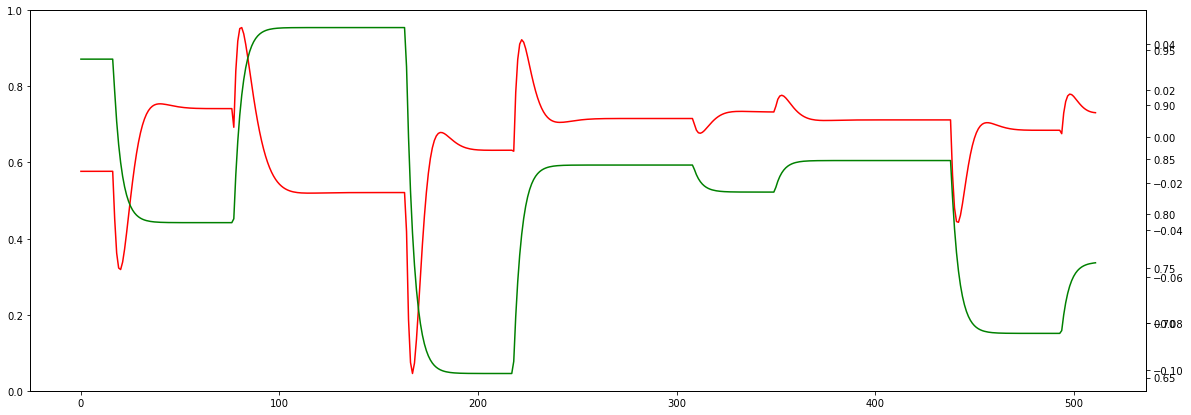

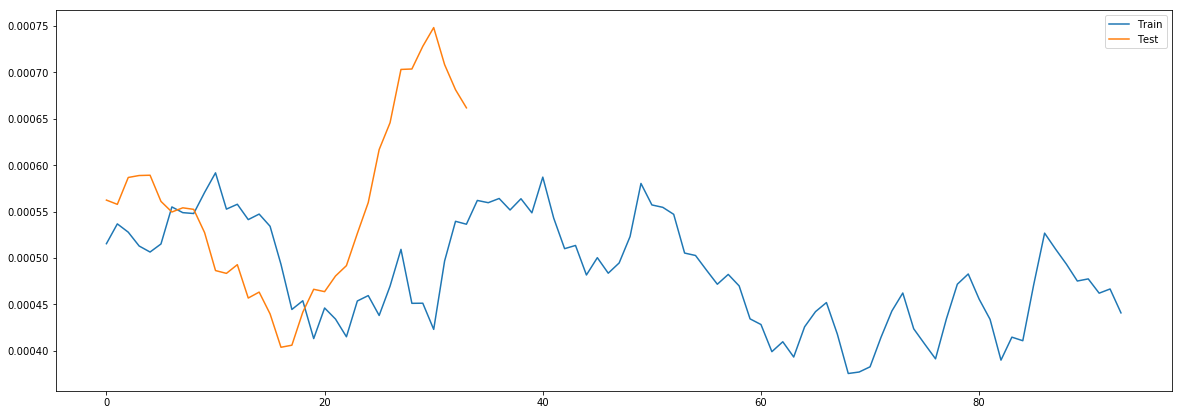

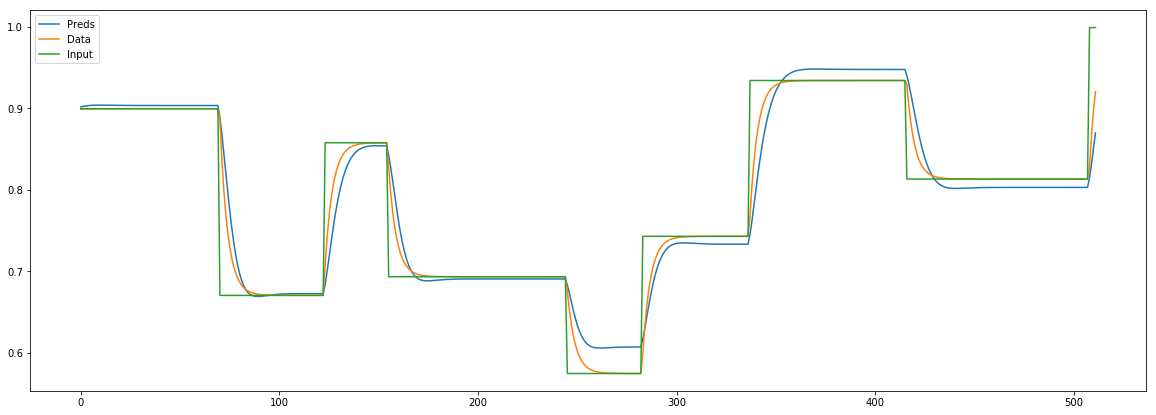

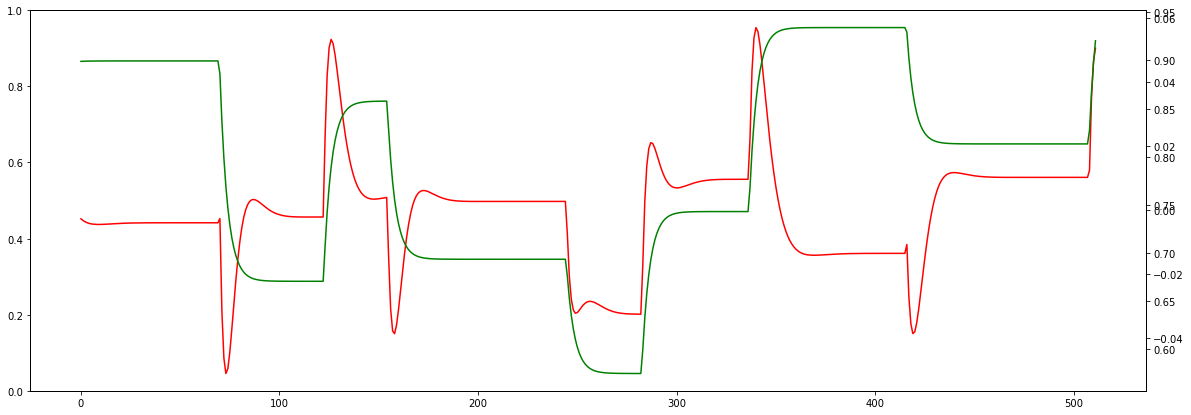

Epoch [3]     
 train_loss[0.0007967284758566306]     
 eval_train[0.0004788793899374119]     
 eval_test[0.0005474081742497881] 


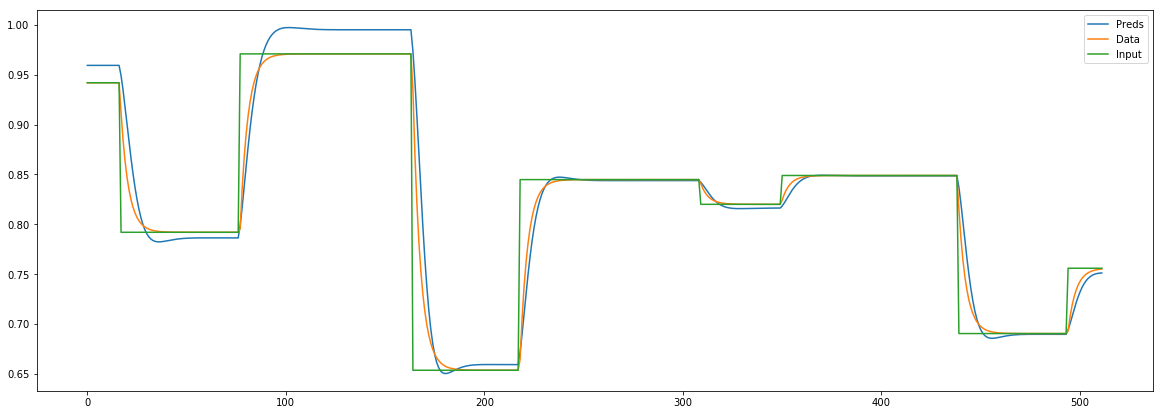

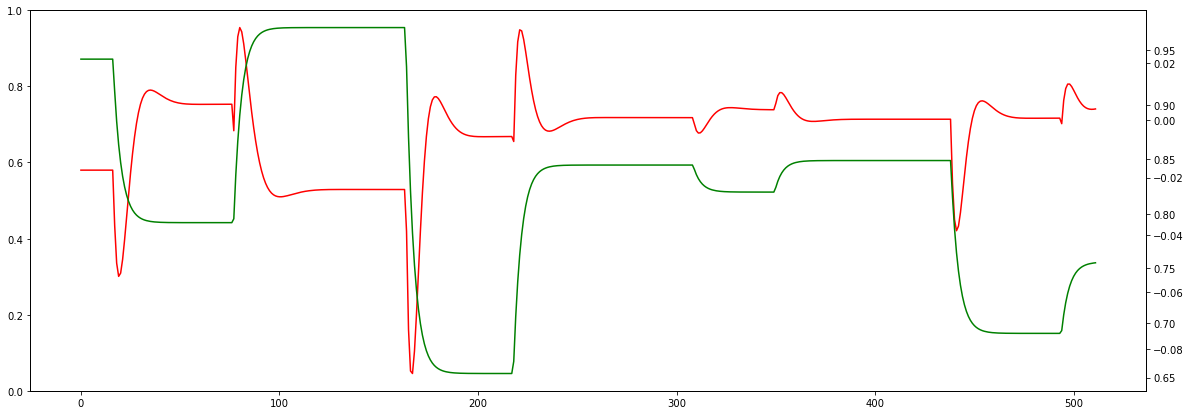

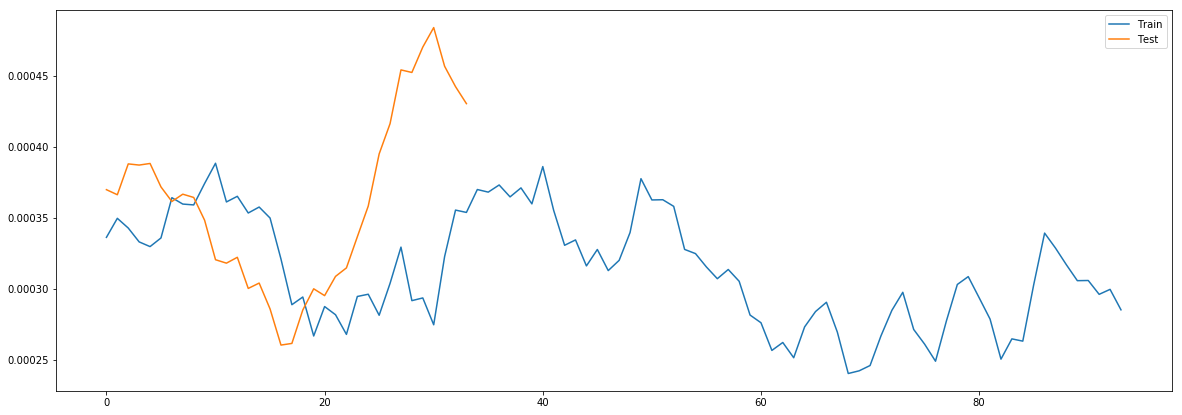

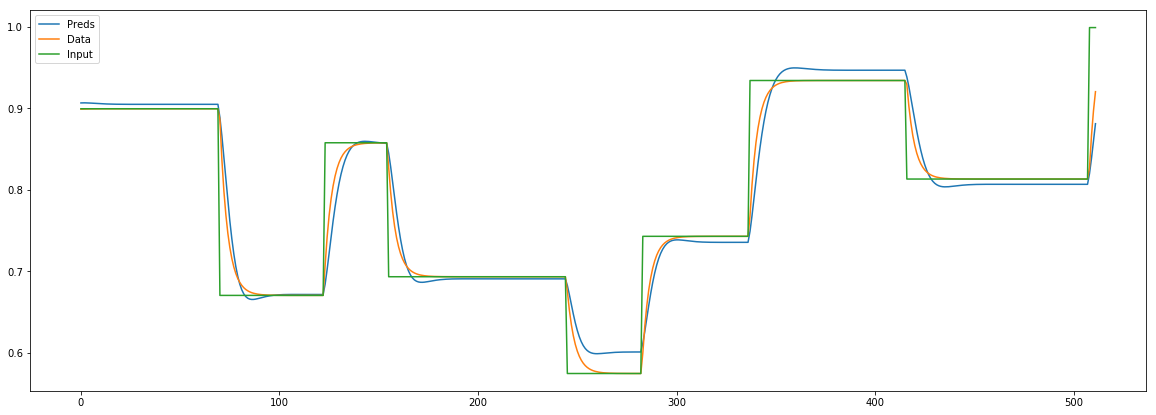

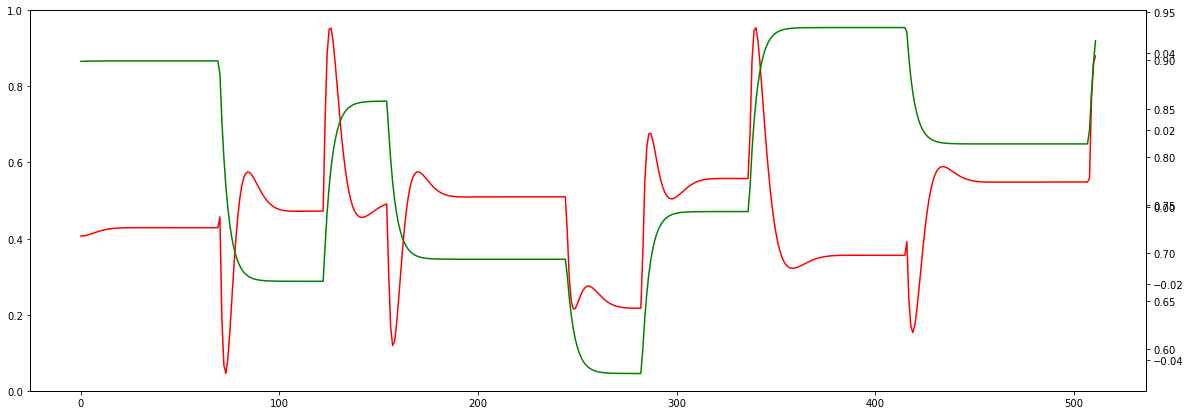

Epoch [4]     
 train_loss[0.00039955739871052524]     
 eval_train[0.0003105949026226321]     
 eval_test[0.0003562484868201533] 


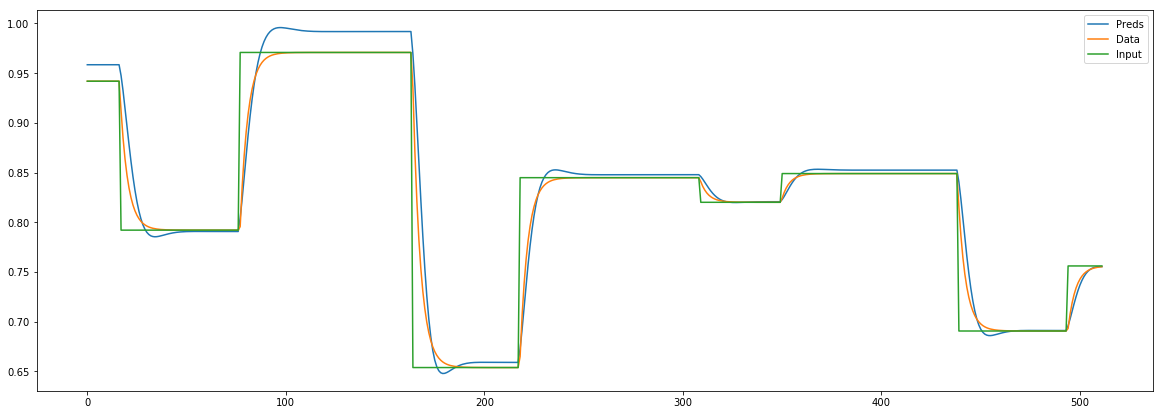

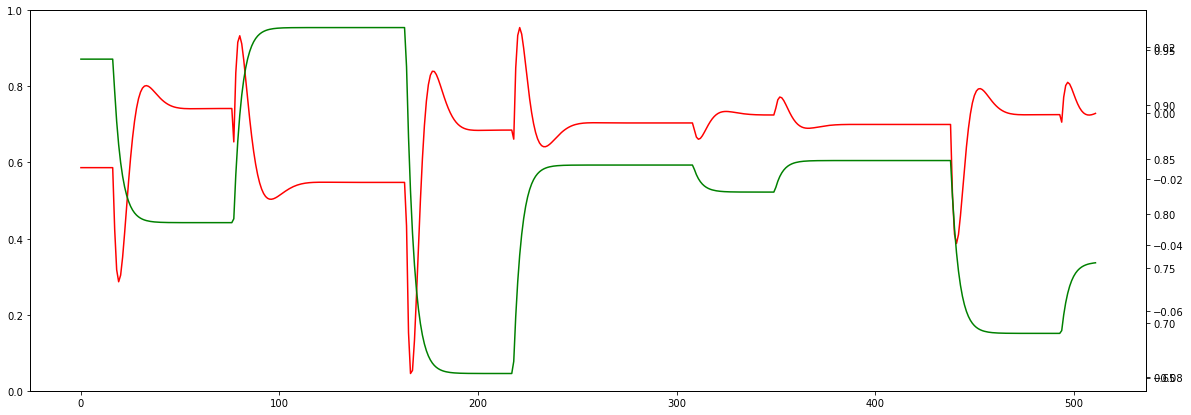

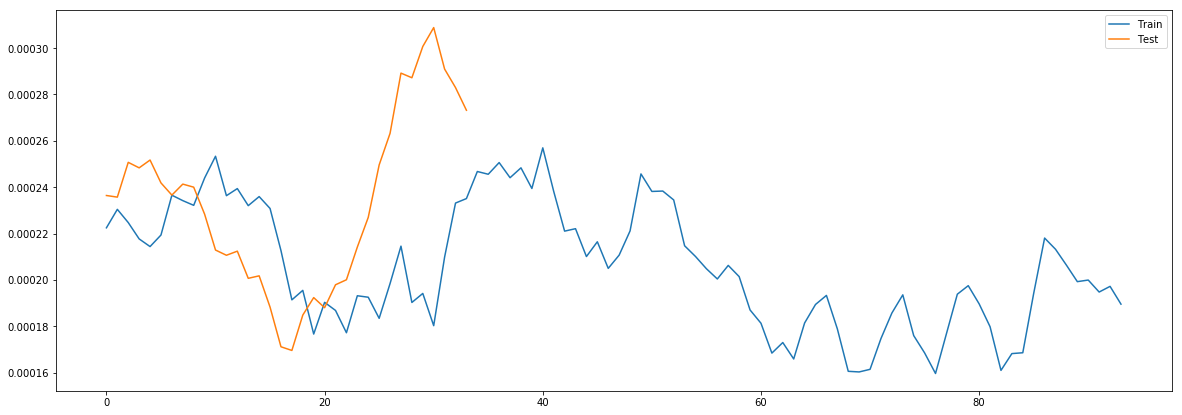

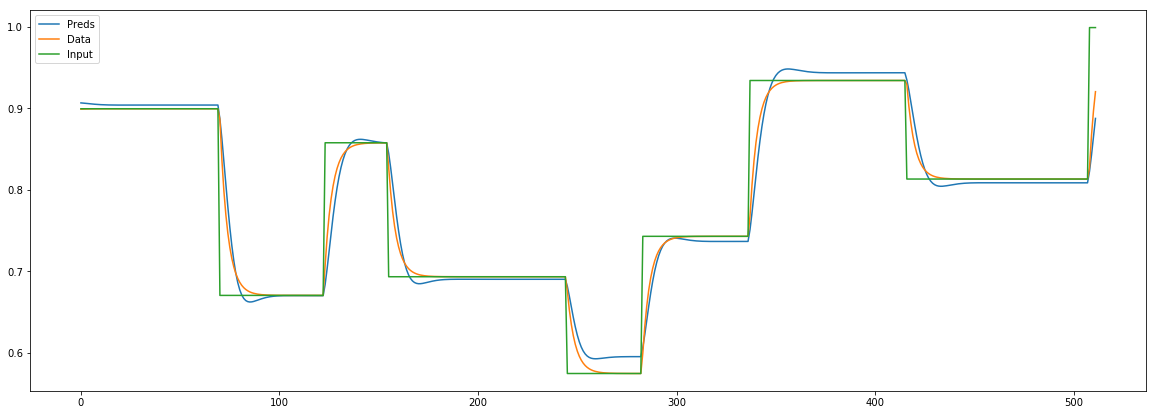

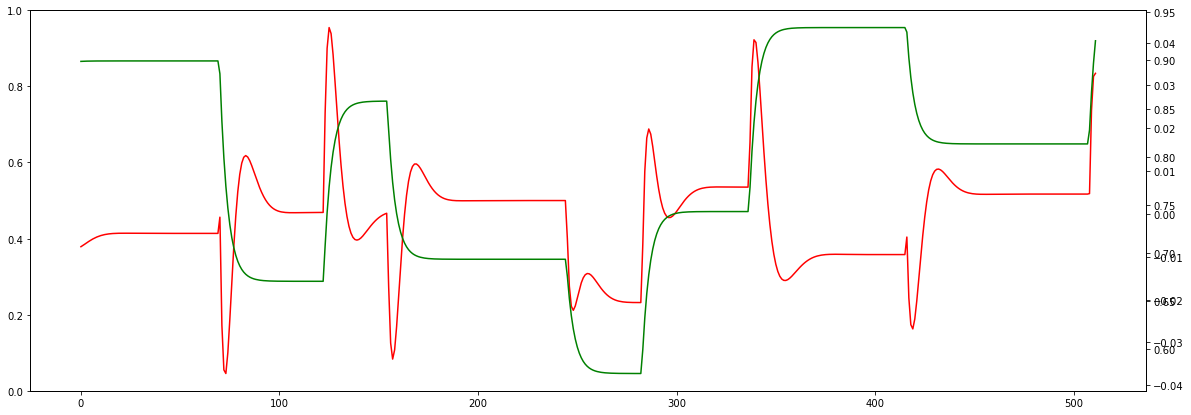

Epoch [5]     
 train_loss[0.00026311340773715457]     
 eval_train[0.00020400514481130254]     
 eval_test[0.00022950614319680344] 


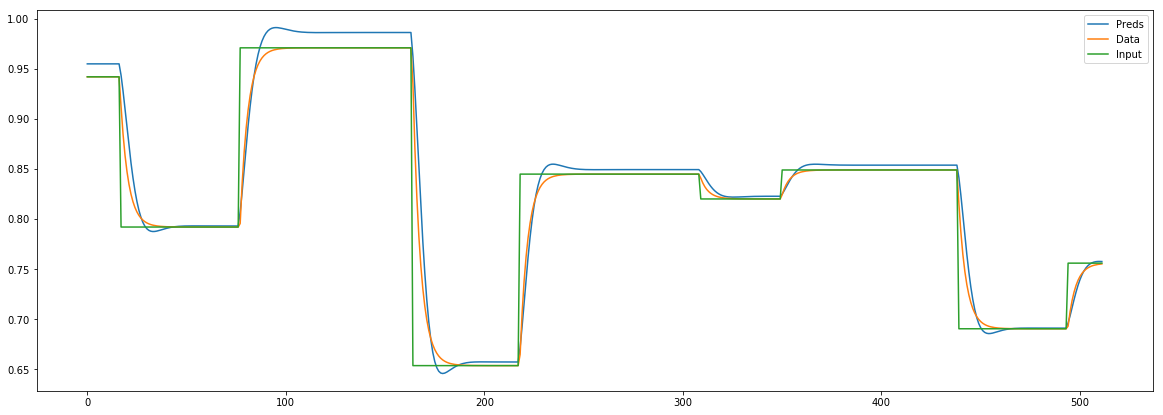

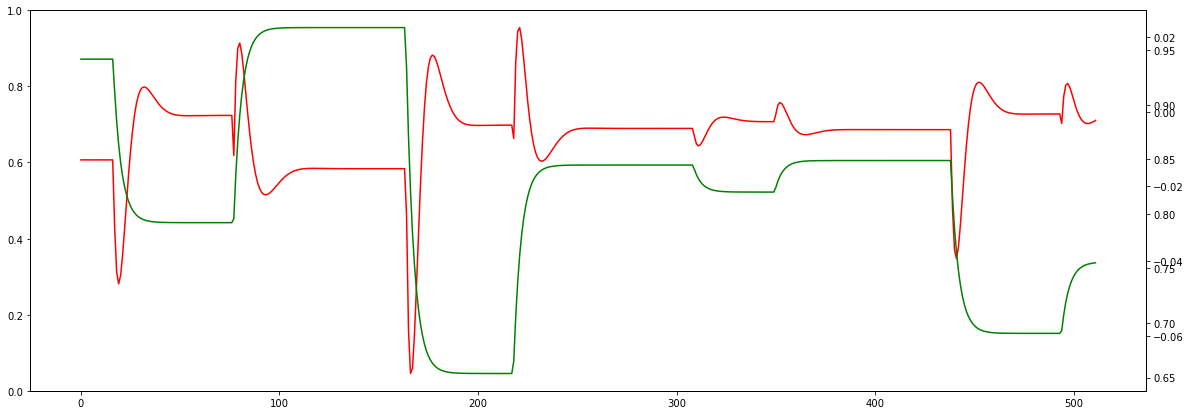

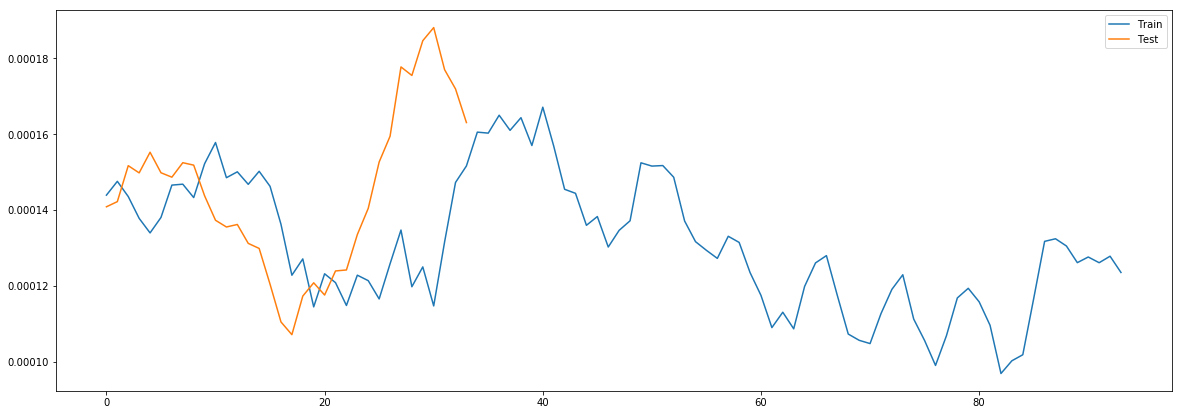

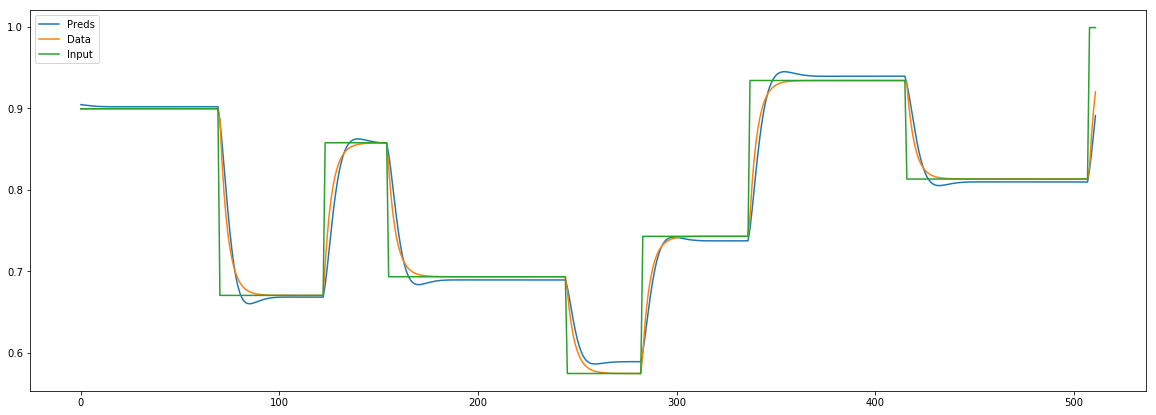

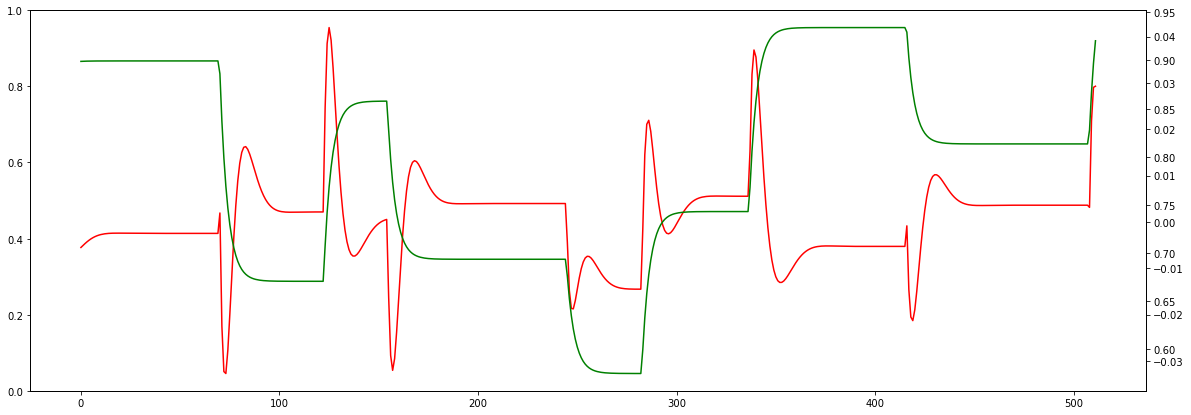

Epoch [6]     
 train_loss[0.00017985841829543532]     
 eval_train[0.00013024053354316633]     
 eval_test[0.00014160778474351073] 


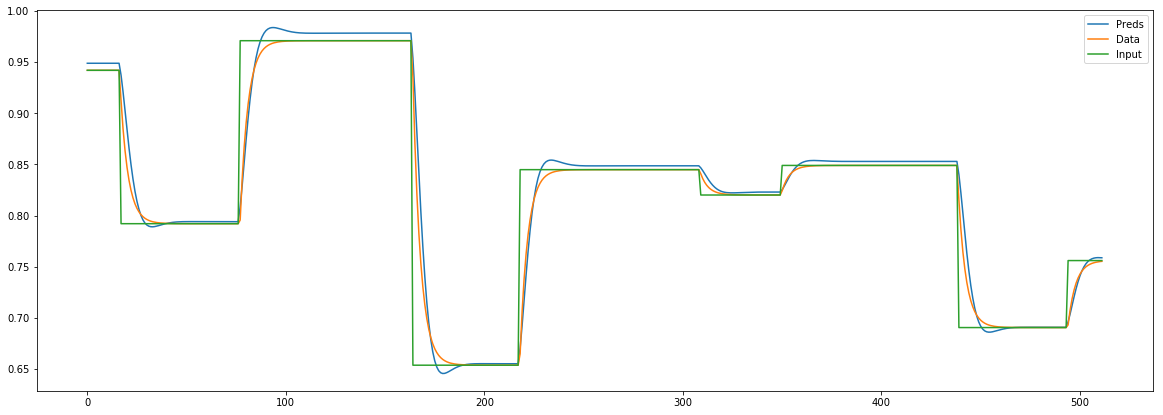

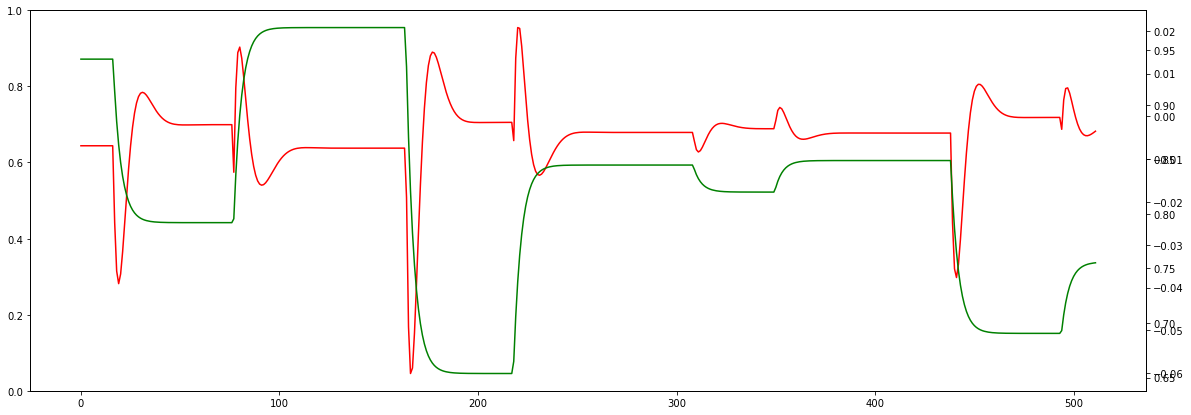

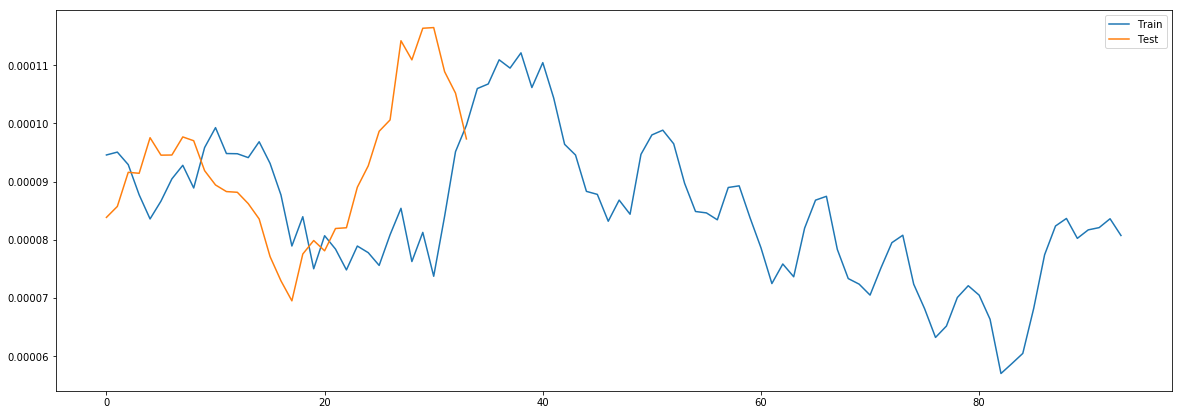

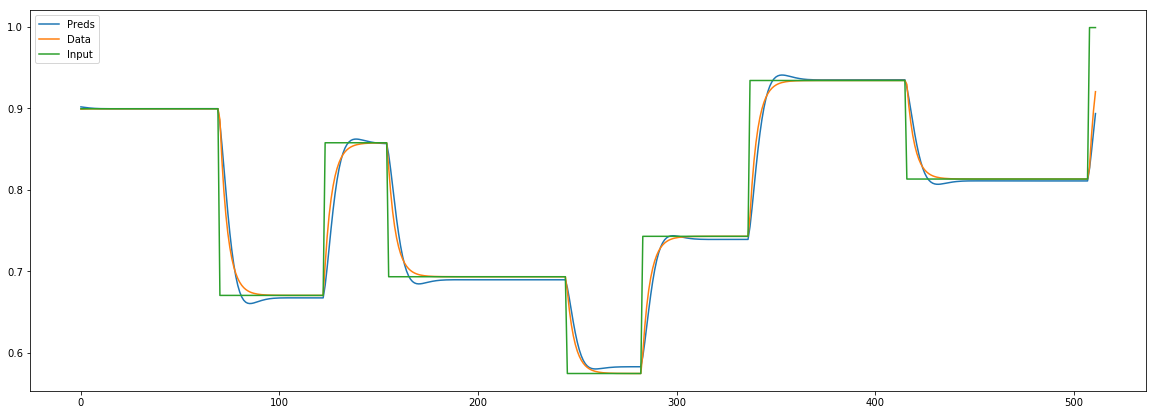

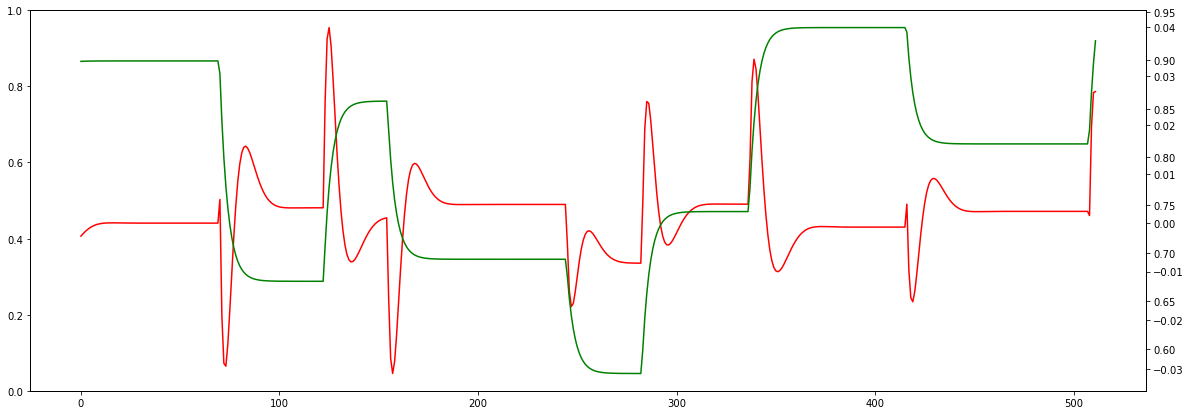

Epoch [7]     
 train_loss[0.0001190700041101641]     
 eval_train[8.441085455720335e-05]     
 eval_test[8.913339752325555e-05] 


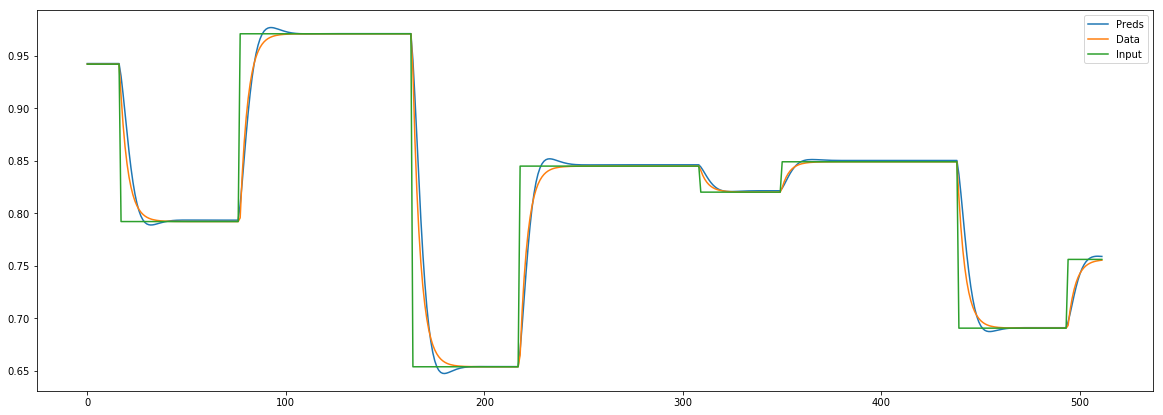

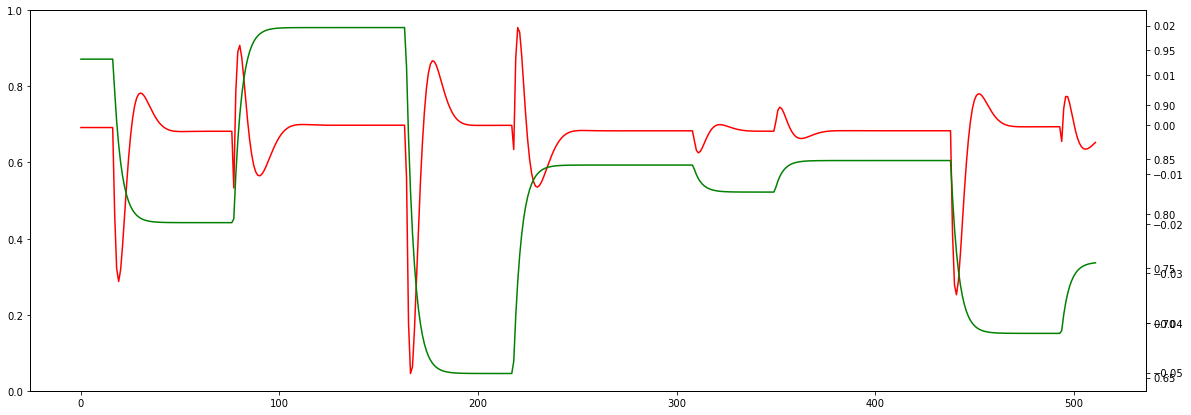

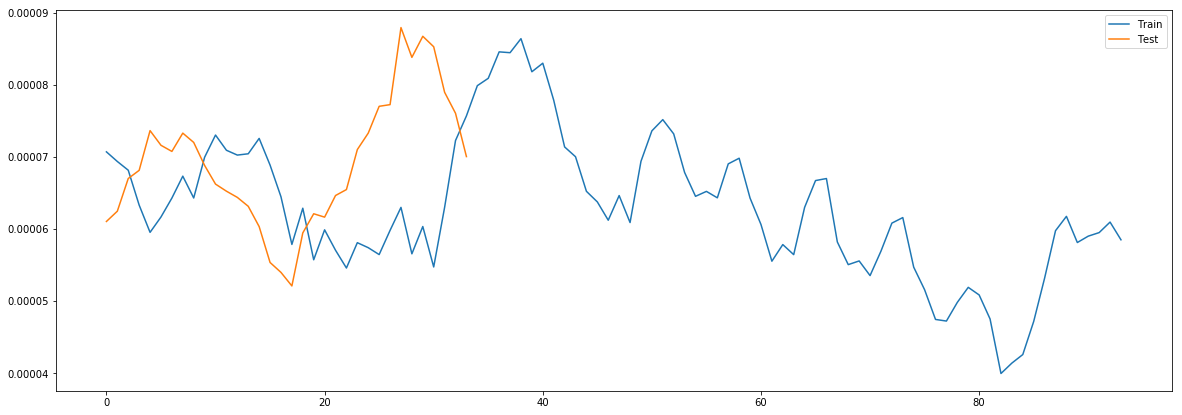

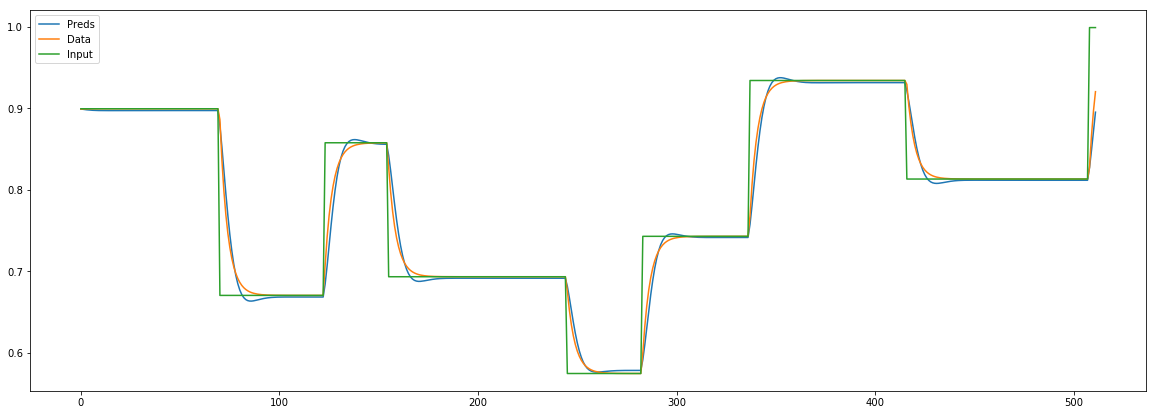

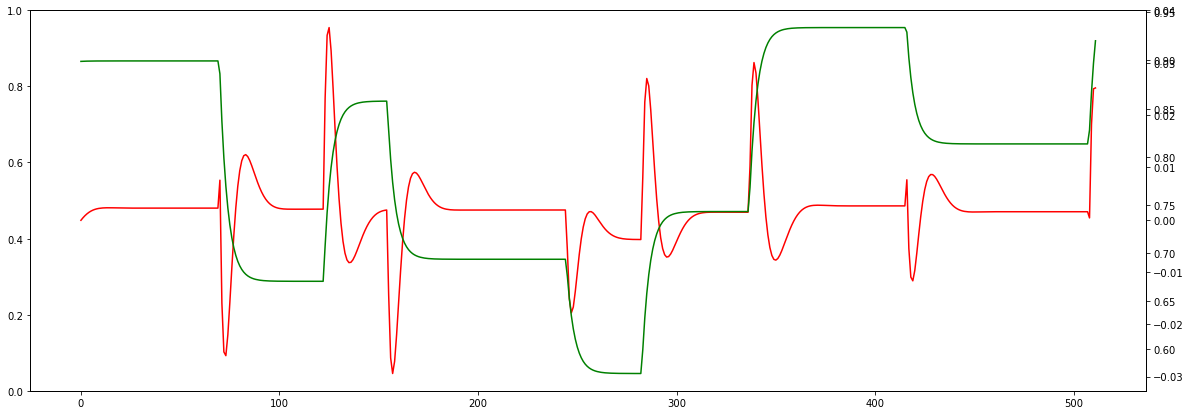

Epoch [8]     
 train_loss[7.908756368543926e-05]     
 eval_train[6.284095563667227e-05]     
 eval_test[6.647073393072456e-05] 


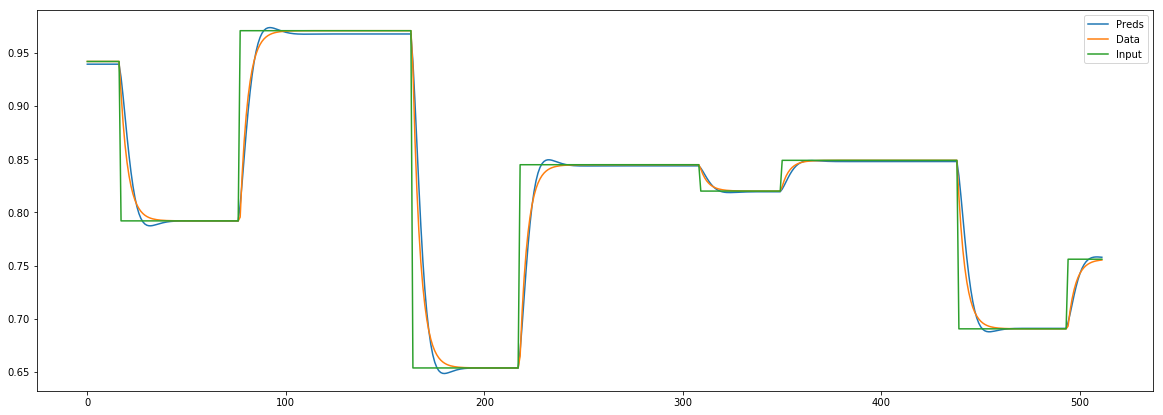

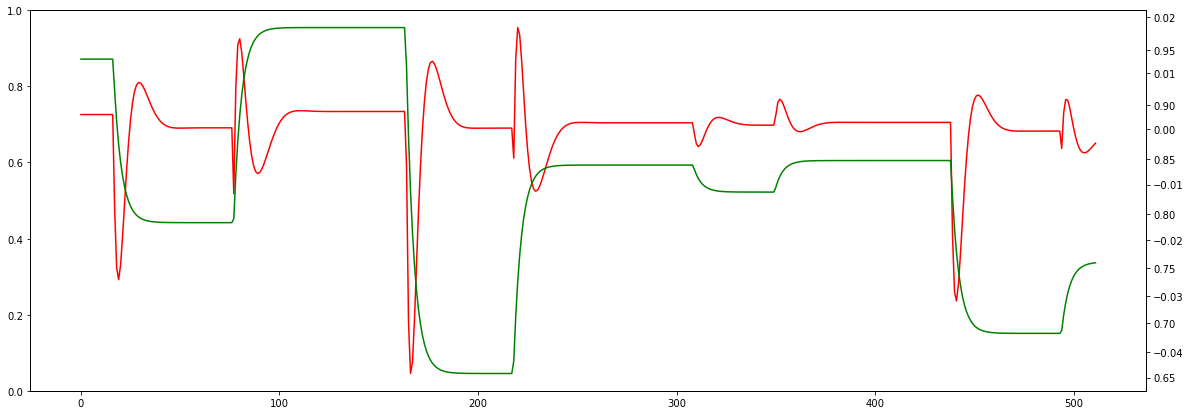

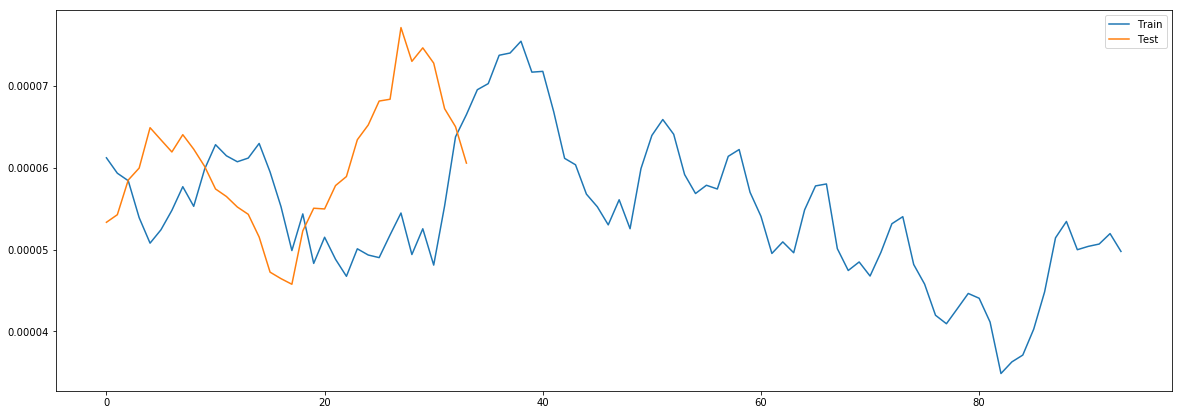

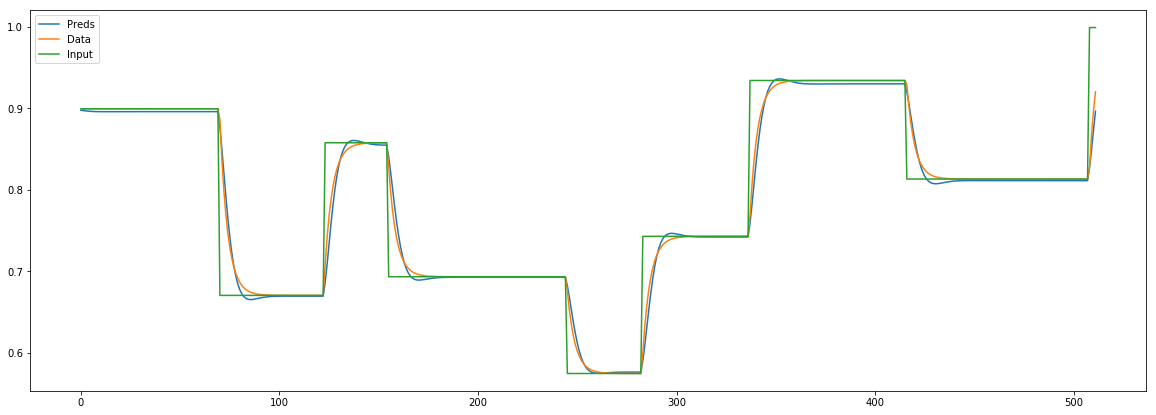

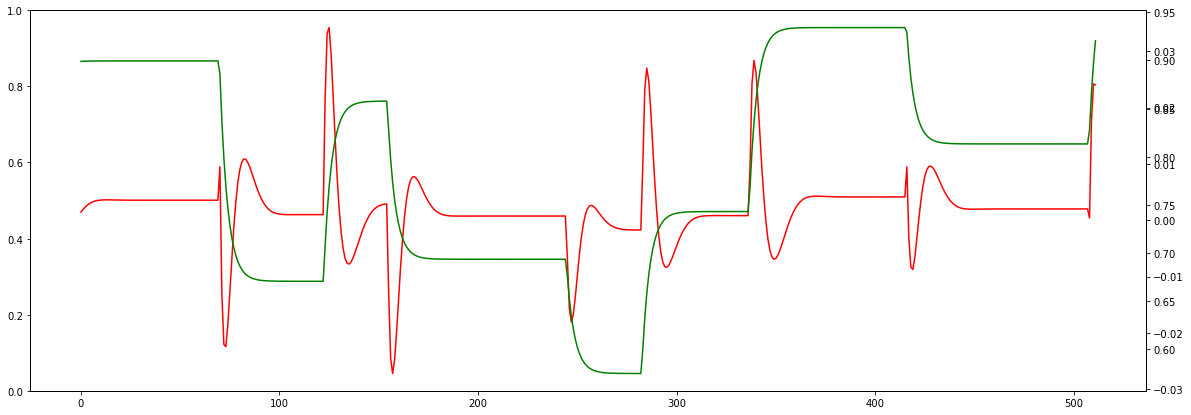

Epoch [9]     
 train_loss[6.084497718242906e-05]     
 eval_train[5.456743158797158e-05]     
 eval_test[5.8052905305058545e-05] 


In [89]:
#####################
# Train model
#####################
num_epochs = 10
model.hidden = model.init_hidden()
hist = {"train_loss":np.zeros(num_epochs), 
        "train_local_loss":np.zeros(len(train_dl)),
        "eval_train_local":np.zeros(len(train_dl)),
         "eval_test_local":np.zeros(len(test_dl)),
        "eval_train":np.zeros(num_epochs),
         "eval_test":np.zeros(num_epochs)
       }

for t in range(num_epochs):
    for i, data in enumerate(tqdm(train_dl)):
        x_batch, y_batch, indexes = data
        x_batch.transpose_(0, 1)
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
        #y_pred, train_loss = train_on_batch(model, x_batch, y_batch)
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)
        hist['train_local_loss'][i] = loss.item()

        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        # Backward pass
        loss.backward()

        # Update parameters
        optimiser.step()
        
    plot_shared_scale(
        [(y_pred.detach().numpy(),"Preds" ),
         (y_batch.detach().numpy(), "Data"),
         (x_batch[-1].detach().numpy(), "Input")])
    residuals = y_batch-y_pred
    plot_multiscale([(residuals.detach().numpy(), "Red"),
                          (y_batch.detach().numpy(), "Green")]) 
    

        # validate during evaluation
    with torch.no_grad():
        model = model.eval()
        for i, data in enumerate(tqdm(train_dl)):
            x_batch, y_batch, indexes = data
            x_batch.transpose_(0, 1)
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            hist['eval_train_local'][i] = loss.item()
        for i, data in enumerate(tqdm(test_dl)):
            x_batch_test, y_batch_test, indexes = data
            x_batch_test.transpose_(0, 1)
            y_pred_test = model(x_batch_test)
            loss = loss_fn(y_pred_test, y_batch_test)
            hist['eval_test_local'][i] = loss.item()
        model = model.train()

        
    smoothed_train = []
    smoothed_test = []
    k_smooth = 10
    for elm in range(hist['eval_train_local'][:-k_smooth].shape[0]):
        smoothed_train.append(np.average(hist['eval_train_local'][elm:elm+k_smooth]))
    for elm in range(hist['eval_test_local'][:-k_smooth].shape[0]):
        smoothed_test.append(np.average(hist['eval_test_local'][elm:elm+k_smooth])) 
    
    plot_shared_scale([
            (smoothed_train,"Train" ),
             (smoothed_test, "Test")])        
    
    plot_shared_scale([
            (y_pred_test.detach().numpy(),"Preds" ),
             (y_batch_test.detach().numpy(), "Data"),
             (x_batch_test[-1].detach().numpy(), "Input")])

    residuals = y_batch_test - y_pred_test
    plot_multiscale(
            [(residuals.detach().numpy(), "Red"), 
             (y_batch_test.detach().numpy(),"Green")])
#     plot_shared_scale( [ (hist["eval_train_local"], "train"),
#                         (hist["eval_test_local"], "test")])
    
    hist["train_loss"][t] = np.average(hist["train_local_loss"])
    hist["eval_train"][t] = np.average(hist["eval_train_local"])
    hist["eval_test"][t] = np.average(hist["eval_test_local"])
    print(f"Epoch [{t}] \
    \n train_loss[{hist['train_loss'][t]}] \
    \n eval_train[{hist['eval_train'][t]}] \
    \n eval_test[{hist['eval_test'][t]}] ")

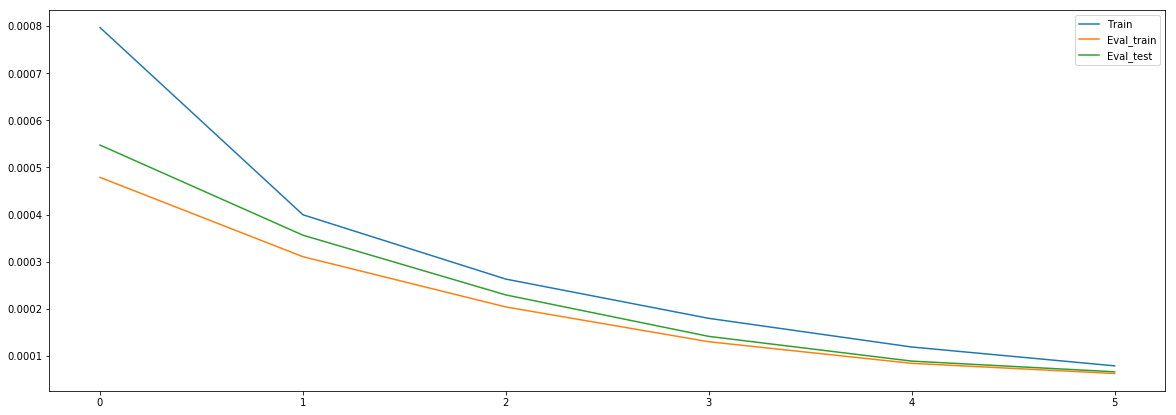

In [91]:
s, e = 3, -1
plot_shared_scale([(hist['train_loss'][s:e],"Train" ),
             (hist['eval_train'][s:e], "Eval_train"),
             (hist['eval_test'][s:e], "Eval_test")])

In [ ]:
model.buffers

In [ ]:
#

In [ ]:
while True:
    pass #piece of code preventing from overwriting previous results

In [ ]:
# TODO place it in the training loop for stopping

In [ ]:
# TODO provide experiment loggiing